# Proyecto 1 - Etapa 2



In [ ]:
%pip install fastapi uvicorn nest_asyncio

In [27]:
# ==============================================================
#  PROYECTO 1 – ETAPA 2 (SECCIÓN 1)
#  Baseline (v1) → Aumentación ODS1 → Reentrenamiento (v2) → Comparación
# ==============================================================

# ========== 1) IMPORTS Y UTILIDADES ==========
import os
import json
import pandas as pd
import numpy as np
from joblib import dump, load
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, f1_score, classification_report)
import matplotlib.pyplot as plt

# tqdm opcional
try:
    from tqdm import tqdm
    tqdm.pandas()
    USE_TQDM = True
except Exception:
    USE_TQDM = False

# ========== 2) LIMPIEZA Y LEMATIZACIÓN ==========
import spacy
try:
    nlp = spacy.load("es_core_news_sm")
except Exception as e:
    raise RuntimeError(
        "Falta el modelo de spaCy para español. Instala con:\n"
        "  python -m spacy download es_core_news_sm"
    ) from e

def clean_text(text):
    text = str(text).lower()
    text = text.replace('\n',' ').replace('\r',' ')
    text = ''.join(ch for ch in text if ch.isalnum() or ch.isspace())
    text = ' '.join(text.split())
    return text

def lemmatize_text(text):
    doc = nlp(text)
    return ' '.join([tok.lemma_ for tok in doc if not tok.is_stop and not tok.is_punct])

def apply_series(func, series):
    if USE_TQDM:
        return series.progress_apply(func)
    return series.apply(func)

100%|██████████| 2424/2424 [02:02<00:00, 19.77it/s]


=== v1 en HOLD-OUT original (Etapa 1) ===
Accuracy: 0.961
F1-macro: 0.956

=== Reporte de clasificación — v1 (baseline en hold-out original) ===
              precision    recall  f1-score   support

           1       0.97      0.90      0.93       101
           3       0.95      0.97      0.96       179
           4       0.97      0.99      0.98       205

    accuracy                           0.96       485
   macro avg       0.96      0.95      0.96       485
weighted avg       0.96      0.96      0.96       485



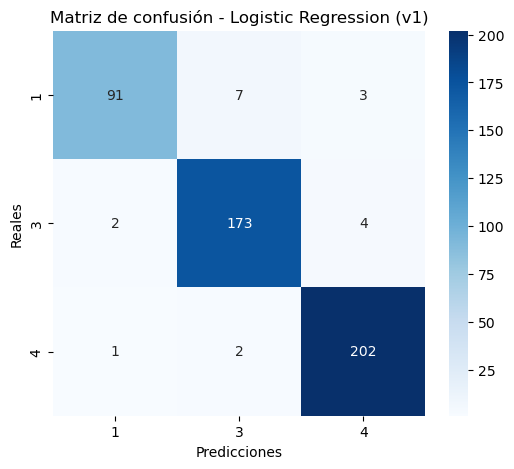

Guardados v1: model_LogisticRegression.joblib, tfidf_vectorizer.joblib



In [28]:
# ========== 3) DATOS ORIGINALES (ETAPA 1) Y v1 ==========
# Cambia el nombre si tu archivo es otro
import seaborn as sns
from sklearn.metrics import confusion_matrix

df_orig = pd.read_excel("data/Datos_proyecto.xlsx")
assert {"textos","labels"} <= set(df_orig.columns), f"Columnas esperadas no encontradas: {df_orig.columns}"

# Preparación idéntica a la Etapa 1
df_orig["texto_limpio"] = apply_series(clean_text, df_orig["textos"].astype(str))
df_orig["texto_lema"]   = apply_series(lemmatize_text, df_orig["texto_limpio"])

# Split reproducible (HOLD-OUT FIJO para comparación v1 vs v2)
X_train, X_test, y_train, y_test = train_test_split(
    df_orig["texto_lema"], df_orig["labels"],
    test_size=0.2, random_state=42, stratify=df_orig["labels"]
)

# Vectorizador y modelo v1 (misma configuración de la Etapa 1)
vectorizer_v1 = TfidfVectorizer(ngram_range=(1,2), min_df=3, max_df=0.9, sublinear_tf=True, norm="l2")
X_train_v1 = vectorizer_v1.fit_transform(X_train)
X_test_v1  = vectorizer_v1.transform(X_test)

logreg_v1 = LogisticRegression(max_iter=2000, solver="lbfgs")
logreg_v1.fit(X_train_v1, y_train)

# Métricas rápidas en el hold-out original (v1)
yhat_v1_hold = logreg_v1.predict(X_test_v1)
print("=== v1 en HOLD-OUT original (Etapa 1) ===")
print("Accuracy:", round(accuracy_score(y_test, yhat_v1_hold), 3))
print("F1-macro:", round(f1_score(y_test, yhat_v1_hold, average='macro'), 3))

# Reporte detallado de clasificación (por clase)
print("\n=== Reporte de clasificación — v1 (baseline en hold-out original) ===")
print(classification_report(y_test, yhat_v1_hold, zero_division=0))

# Matriz de confusión
cm = confusion_matrix(y_test, yhat_v1_hold, labels=logreg_v1.classes_)

plt.figure(figsize=(6,5))
sns.heatmap(cm,
            annot=True,          # muestra los números
            fmt="d",             # formato enteros
            cmap="Blues",        # paleta de colores
            xticklabels=logreg_v1.classes_,  # nombres de clases eje X
            yticklabels=logreg_v1.classes_)  # nombres de clases eje Y
plt.xlabel("Predicciones")
plt.ylabel("Reales")
plt.title("Matriz de confusión - Logistic Regression (v1)")
plt.show()

# Guardar artefactos v1
dump(logreg_v1, "artifacts/model_LogisticRegression.joblib")
dump(vectorizer_v1, "artifacts/tfidf_vectorizer.joblib")
print("Guardados v1: model_LogisticRegression.joblib, tfidf_vectorizer.joblib\n")


Nuevo dataset: filas=99 | columna texto='textos'


100%|██████████| 99/99 [00:07<00:00, 13.73it/s]



=== Reporte de clasificación — v1 (baseline en nuevo set) ===
              precision    recall  f1-score   support

           1       1.00      0.57      0.73        21
           3       0.85      1.00      0.92        35
           4       0.89      0.95      0.92        43

    accuracy                           0.89        99
   macro avg       0.91      0.84      0.86        99
weighted avg       0.90      0.89      0.88        99



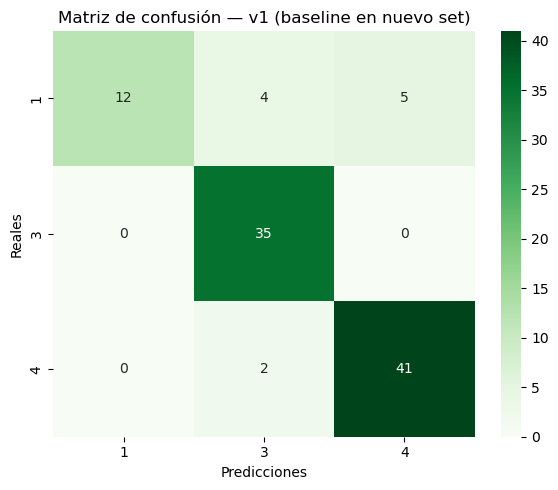

Baseline (v1) en nuevo set listo:
baseline_etapa2_macro.csv
baseline_etapa2_por_clase.csv
predicciones_v1_en_nuevo_set.csv
matriz_confusion_v1_nuevo_set.png



In [ ]:
# ========== 4) NUEVO SET (ETAPA 2) → BASELINE CON v1 ==========
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Cambia el nombre si tu archivo es otro
df_new = pd.read_excel("data/Datos_Etapa 2.xlsx")

# Detecta columna de texto
TEXT_COL = "Textos_espanol" if "Textos_espanol" in df_new.columns else ("textos" if "textos" in df_new.columns else None)
assert TEXT_COL is not None, f"No encuentro columna de texto. Columnas: {list(df_new.columns)}"
assert "labels" in df_new.columns, f"Falta columna 'labels' en df_new."

print(f"Nuevo dataset: filas={len(df_new)} | columna texto='{TEXT_COL}'")

# Limpieza y lematización (idéntico a Etapa 1)
df_new["texto_limpio"] = apply_series(clean_text, df_new[TEXT_COL].astype(str))
df_new["texto_lema"]   = apply_series(lemmatize_text, df_new["texto_limpio"])

# Baseline v1 en el nuevo set
X_new = vectorizer_v1.transform(df_new["texto_lema"])
y_new = df_new["labels"]
yhat_new = logreg_v1.predict(X_new)

# Reporte y métricas
rep_new_v1 = classification_report(y_new, yhat_new, output_dict=True, zero_division=0)
pd.DataFrame(rep_new_v1).to_csv("outputs/baseline_etapa2_por_clase.csv")

pd.DataFrame([{
    "accuracy": accuracy_score(y_new, yhat_new),
    "f1_macro": f1_score(y_new, yhat_new, average="macro")
}]).to_csv("outputs/baseline_etapa2_macro.csv", index=False)

df_new.assign(pred_v1=yhat_new).to_csv("outputs/predicciones_v1_en_nuevo_set.csv", index=False)

# === Reporte detallado ===
print("\n=== Reporte de clasificación — v1 (baseline en nuevo set) ===")
print(classification_report(y_new, yhat_new, zero_division=0))

# === Matriz de confusión ===
cm_new = confusion_matrix(y_new, yhat_new, labels=logreg_v1.classes_)

plt.figure(figsize=(6,5))
sns.heatmap(cm_new,
            annot=True,          # muestra los números
            fmt="d",             # formato enteros
            cmap="Greens",       # paleta de colores
            xticklabels=logreg_v1.classes_,
            yticklabels=logreg_v1.classes_)
plt.xlabel("Predicciones")
plt.ylabel("Reales")
plt.title("Matriz de confusión — v1 (baseline en nuevo set)")
plt.tight_layout()
plt.savefig("figures/matriz_confusion_v1_nuevo_set.png", dpi=150)
plt.show()

print("Baseline (v1) en nuevo set listo:")
print("baseline_etapa2_macro.csv")
print("baseline_etapa2_por_clase.csv")
print("predicciones_v1_en_nuevo_set.csv")
print("matriz_confusion_v1_nuevo_set.png\n")


In [30]:
# ========== 5) AUMENTACIÓN POR PROMPTING (ODS 1) ==========
# Inferir formato de etiqueta (strings 'ODS1' vs numéricos 1)
def infer_label_format(series):
    s = series.dropna().astype(str)
    if (s.str.contains("ODS", case=False)).mean() > 0.5:
        return "string"
    # numérico?
    s_num = pd.to_numeric(s, errors="coerce")
    if s_num.notna().mean() > 0.5:
        return "numeric"
    return "string"

label_format = infer_label_format(pd.concat([df_orig["labels"], df_new["labels"]], ignore_index=True))
ODS1_LABEL = "ODS1" if label_format == "string" else 1

# >>> Textos sintéticos (5 ejemplos; agrega más si quieres 300–600) <<<
lista_textos_sinteticos = [
    "En mi barrio muchas familias viven del rebusque y cuando no hay ventas, no hay comida en la mesa. A veces toca decidir entre pagar el transporte o comprar lo del almuerzo. No hay empleos estables y los subsidios no alcanzan para cubrir lo básico. La gente se las ingenia, pero la vida sigue siendo muy dura para quienes vivimos del día a día.",
    "Trabajo como madre cabeza de hogar en una tienda pequeña y el dinero apenas alcanza para el arriendo y los servicios. Mis hijos muchas veces se quedan sin desayuno antes de ir al colegio. Cada mes todo sube, pero los ingresos siguen iguales. La sensación de vivir con lo justo, sin poder ahorrar, es agotadora.",
    "En las veredas del Cauca muchos campesinos no tienen acceso a vías ni a mercados donde vender sus productos. El transporte es caro y los intermediarios se quedan con casi todo. A veces uno siente que trabaja mucho y gana muy poco. La pobreza aquí no solo es falta de dinero, sino de oportunidades reales para salir adelante.",
    "Soy joven y terminé el bachillerato, pero conseguir trabajo formal ha sido imposible. En mi zona solo hay opciones informales con pagos muy bajos. He pensado en estudiar, pero el costo del transporte y los materiales me lo impiden. Quiero progresar, pero siento que la pobreza no me deja avanzar.",
    "En la costa, muchas familias viven sin agua constante ni empleo seguro. Los niños se enferman porque el agua no es limpia y toca comprar botellones que son costosos. La mayoría sobrevive vendiendo dulces o haciendo oficios por días. Todos soñamos con un trabajo fijo que nos permita vivir con dignidad."
]

# Limpieza + lemas + control de calidad (umbral tokens 8–200 tras lematizar)
df_sint = pd.DataFrame({"texto": lista_textos_sinteticos}).dropna()
df_sint["texto"] = df_sint["texto"].astype(str).str.strip()
df_sint["texto_limpio"] = apply_series(clean_text, df_sint["texto"])
df_sint["texto_lema"]   = apply_series(lemmatize_text, df_sint["texto_limpio"])
df_sint["n_tokens"]     = df_sint["texto_lema"].str.split().str.len()

MIN_TOKENS, MAX_TOKENS = 8, 200
df_sint = df_sint[df_sint["n_tokens"].between(MIN_TOKENS, MAX_TOKENS)]

# Quitar duplicados internos
df_sint = df_sint.drop_duplicates(subset="texto_lema").copy()

# Quitar duplicados exactos contra el nuevo set (y original si lo deseas)
existing = pd.concat([
    df_new[["texto_lema"]],
    df_orig[["texto_lema"]]
], ignore_index=True).drop_duplicates()

df_sint = df_sint.merge(existing.assign(_e=1), on="texto_lema", how="left")
cross_dups = int(df_sint["_e"].fillna(0).sum())
df_sint = df_sint[df_sint["_e"].isna()].drop(columns=["_e"])

df_sint = df_sint.assign(labels=ODS1_LABEL)[["texto_lema","labels"]].reset_index(drop=True)
df_sint.to_csv("data/synthetic_ODS1_clean.csv", index=False)
print(f"✔ Sintéticos válidos: {len(df_sint)} (quitados por duplicados vs datasets: {cross_dups}) → synthetic_ODS1_clean.csv\n")


100%|██████████| 5/5 [00:00<00:00, 21.54it/s]

✔ Sintéticos válidos: 5 (quitados por duplicados vs datasets: 0) → synthetic_ODS1_clean.csv



=== v2 en MISMO HOLD-OUT (Etapa 1) ===
Accuracy: 0.961
F1-macro: 0.956

=== Reporte de clasificación — v2 (reentrenado en hold-out original) ===
              precision    recall  f1-score   support

           1       0.96      0.91      0.93       101
           3       0.96      0.97      0.96       179
           4       0.97      0.98      0.97       205

    accuracy                           0.96       485
   macro avg       0.96      0.95      0.96       485
weighted avg       0.96      0.96      0.96       485



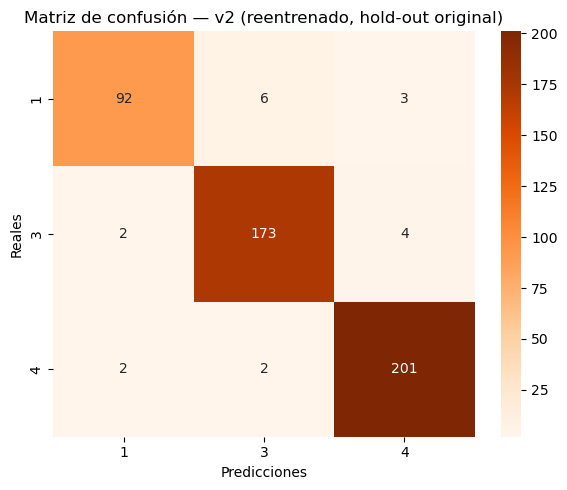

✔ Guardados v2: model_LogisticRegression_v2.joblib, tfidf_vectorizer_v2.joblib
✔ Matriz de confusión guardada: matriz_confusion_v2_holdout.png



In [31]:
# ========== 6) REENTRENAMIENTO (v2) ==========
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Train v2 con: train original + nuevo set + sintéticos (sin tocar el test original)
df_train_v2 = pd.DataFrame({"texto_lema": X_train.values, "labels": y_train.values})
df_train_v2 = pd.concat([df_train_v2, df_new[["texto_lema","labels"]], df_sint], ignore_index=True)

# Vectorizador y modelo v2 (idéntica configuración que v1)
vectorizer_v2 = TfidfVectorizer(ngram_range=(1,2), min_df=3, max_df=0.9, sublinear_tf=True, norm="l2")
Xtr2 = vectorizer_v2.fit_transform(df_train_v2["texto_lema"])
ytr2 = df_train_v2["labels"].values

logreg_v2 = LogisticRegression(max_iter=2000, solver="lbfgs")
logreg_v2.fit(Xtr2, ytr2)

# Evaluar v2 en el MISMO test original (comparación justa)
X_test_v2 = vectorizer_v2.transform(X_test)
yhat_v2_hold = logreg_v2.predict(X_test_v2)

# === Métricas principales ===
print("=== v2 en MISMO HOLD-OUT (Etapa 1) ===")
print("Accuracy:", round(accuracy_score(y_test, yhat_v2_hold), 3))
print("F1-macro:", round(f1_score(y_test, yhat_v2_hold, average="macro"), 3))

# === Reporte detallado ===
print("\n=== Reporte de clasificación — v2 (reentrenado en hold-out original) ===")
print(classification_report(y_test, yhat_v2_hold, zero_division=0))

# === Matriz de confusión ===
cm_v2 = confusion_matrix(y_test, yhat_v2_hold, labels=logreg_v2.classes_)

plt.figure(figsize=(6,5))
sns.heatmap(cm_v2,
            annot=True,          # muestra los números
            fmt="d",             # formato enteros
            cmap="Oranges",      # paleta de colores (naranja para diferenciar del v1)
            xticklabels=logreg_v2.classes_,
            yticklabels=logreg_v2.classes_)
plt.xlabel("Predicciones")
plt.ylabel("Reales")
plt.title("Matriz de confusión — v2 (reentrenado, hold-out original)")
plt.tight_layout()
plt.show()

# Guardar artefactos v2
dump(logreg_v2, "artifacts/model_LogisticRegression_v2.joblib")
dump(vectorizer_v2, "artifacts/tfidf_vectorizer_v2.joblib")
print("✔ Guardados v2: model_LogisticRegression_v2.joblib, tfidf_vectorizer_v2.joblib")
print("✔ Matriz de confusión guardada: matriz_confusion_v2_holdout.png\n")



✔ Comparación guardada: tabla_comparativa_v1_vs_v2_mismo_test.csv
                 Modelo  Accuracy  F1_macro      F1_1      F1_3      F1_4
0  v1 (sin aumentación)  0.960825  0.955876  0.933333  0.958449  0.975845
1  v2 (con aumentación)  0.960825  0.956162  0.934010  0.961111  0.973366 

✔ Gráfico guardado: f1_por_clase_mismo_test.png


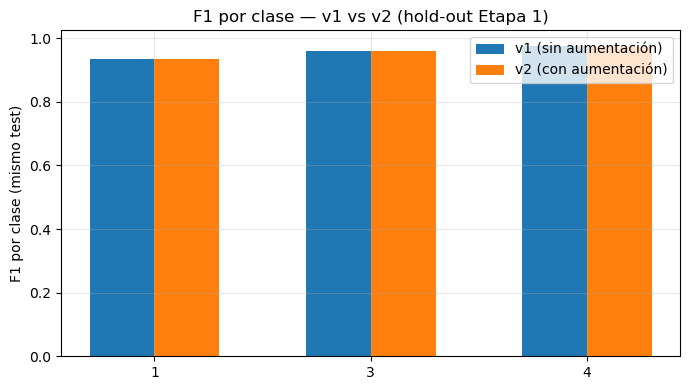

In [32]:
# ========== 7) COMPARACIÓN v1 vs v2 EN MISMO TEST ==========
def fila_resumen(y_true, y_pred, nombre):
    rep = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    out = {
        "Modelo": nombre,
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1_macro": f1_score(y_true, y_pred, average="macro")
    }
    # F1 por clase (usa las etiquetas presentes en y_true)
    for cls in sorted(pd.Series(y_true).unique(), key=lambda x: str(x)):
        key = str(cls)
        if key in rep:
            out[f"F1_{key}"] = rep[key]["f1-score"]
    return out, rep

fila_v1, rep_v1 = fila_resumen(y_test, yhat_v1_hold, "v1 (sin aumentación)")
fila_v2, rep_v2 = fila_resumen(y_test, yhat_v2_hold, "v2 (con aumentación)")

tabla_comp = pd.DataFrame([fila_v1, fila_v2])
tabla_comp.to_csv("figures/tabla_comparativa_v1_vs_v2_mismo_test.csv", index=False)
print("✔ Comparación guardada: tabla_comparativa_v1_vs_v2_mismo_test.csv")
print(tabla_comp, "\n")

# (Opcional) F1 por clase (gráfico)
try:
    labels_test = sorted(pd.Series(y_test).unique(), key=lambda x: str(x))
    f1_v1_cls = [rep_v1.get(str(c), {}).get("f1-score", np.nan) for c in labels_test]
    f1_v2_cls = [rep_v2.get(str(c), {}).get("f1-score", np.nan) for c in labels_test]

    x = np.arange(len(labels_test))
    plt.figure(figsize=(7,4))
    plt.bar(x-0.15, f1_v1_cls, width=0.3, label="v1 (sin aumentación)")
    plt.bar(x+0.15, f1_v2_cls, width=0.3, label="v2 (con aumentación)")
    xticks_labels = [str(c) if isinstance(c, str) else (f"ODS{c}" if isinstance(c,int) else str(c)) for c in labels_test]
    plt.xticks(x, xticks_labels)
    plt.ylabel("F1 por clase (mismo test)")
    plt.title("F1 por clase — v1 vs v2 (hold-out Etapa 1)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig("figures/f1_por_clase_mismo_test.png", dpi=150)
    # plt.show()
    print("✔ Gráfico guardado: f1_por_clase_mismo_test.png")
except Exception as e:
    print("No se pudo crear el gráfico F1 por clase:", e)


In [33]:
# ========== 8) (Opcional) v2 en NUEVO SET (misma comparación justa si reportas ambos) ==========
X_new_v2 = vectorizer_v2.transform(df_new["texto_lema"])
yhat_new_v2 = logreg_v2.predict(X_new_v2)
rep_new_v2  = classification_report(y_new, yhat_new_v2, output_dict=True, zero_division=0)
pd.DataFrame(rep_new_v2).to_csv("outputs/nuevo_set_v2_por_clase.csv")
print("✔ Métricas v2 en nuevo set guardadas: nuevo_set_v2_por_clase.csv")

✔ Métricas v2 en nuevo set guardadas: nuevo_set_v2_por_clase.csv


### Construcción del pipeline

In [34]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

X = df_train_v2["texto_lema"]
y = df_train_v2["labels"]

def build_pipeline():
    pipe = Pipeline([
        ("tfidf", TfidfVectorizer(
            ngram_range=(1,2),
            min_df=3,
            max_df=0.9,
            sublinear_tf=True,
            norm="l2"
        )),
        ("clf", LogisticRegression(
            max_iter=2000,
            solver="lbfgs",
            random_state=42,
            class_weight="balanced"
        ))
    ])
    
    return pipe

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(build_pipeline(), X, y, cv=cv, scoring="f1_macro", n_jobs=-1)
print("Scores por fold:", scores)
print("F1_macro promedio:", scores.mean(), "±", scores.std())

Scores por fold: [0.9787282  0.98864552 0.96458469 0.97655401 0.97689384]
F1_macro promedio: 0.9770812506422896 ± 0.007654042952760502


### Guardar el modelo

In [ ]:
import joblib
from pathlib import Path
from datetime import datetime

MODEL_DIR = Path("models")
MODEL_DIR.mkdir(exist_ok=True)

CURRENT_MODEL_PATH = MODEL_DIR / "model_current.joblib"

def save_model(pipe, replace_current=True):
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    versioned = MODEL_DIR / f"model_{ts}.joblib"
    joblib.dump(pipe, versioned)
    if replace_current:
        joblib.dump(pipe, CURRENT_MODEL_PATH)
    return str(versioned)

def load_current_model():
    return joblib.load(CURRENT_MODEL_PATH)
